<a href="https://colab.research.google.com/github/mahima-c/Stock-Market-Forecasting/blob/main/Stock_Prize_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Stock Market Prediction and Forecasting Using stacked LSTM**

In [1]:
# data Collection

import pandas_datareader as pdr
import os

In [3]:
TIINGO_API_KEY="85f767849d48ecab3d73e334589408a866c2a229"
df=df = pdr.get_data_tiingo('AAPL', api_key=TIINGO_API_KEY)

In [4]:
df.head()

close    high  ...  divCash  splitFactor
symbol date                                       ...                      
AAPL   2015-12-24 00:00:00+00:00  108.03  109.00  ...      0.0          1.0
       2015-12-28 00:00:00+00:00  106.82  107.69  ...      0.0          1.0
       2015-12-29 00:00:00+00:00  108.74  109.43  ...      0.0          1.0
       2015-12-30 00:00:00+00:00  107.32  108.70  ...      0.0          1.0
       2015-12-31 00:00:00+00:00  105.26  107.03  ...      0.0          1.0

[5 rows x 12 columns]

In [5]:
df.to_csv('appl.csv')

In [6]:
import pandas as pd
df=pd.read_csv("appl.csv")
df.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,AAPL,2015-12-24 00:00:00+00:00,108.03,109.00,107.9500,109.00,13596680,25.018514,25.243155,24.999987,25.243155,54386720,0.0,1.0
1,AAPL,2015-12-28 00:00:00+00:00,106.82,107.69,106.1807,107.59,26704210,24.738292,24.939774,24.590238,24.916616,106816840,0.0,1.0
2,AAPL,2015-12-29 00:00:00+00:00,108.74,109.43,106.8600,106.96,30931243,25.182942,25.342738,24.747556,24.770715,123724972,0.0,1.0
3,AAPL,2015-12-30 00:00:00+00:00,107.32,108.70,107.1800,108.58,25213777,24.854087,25.173679,24.821664,25.145888,100855108,0.0,1.0
4,AAPL,2015-12-31 00:00:00+00:00,105.26,107.03,104.8200,107.01,40912316,24.377014,24.786926,24.275115,24.782294,163649264,0.0,1.0


In [7]:
df1=df.reset_index()['close']

In [8]:
df1

0       108.030
1       106.820
2       108.740
3       107.320
4       105.260
         ...   
1252    127.880
1253    127.810
1254    128.700
1255    126.655
1256    128.230
Name: close, Length: 1257, dtype: float64

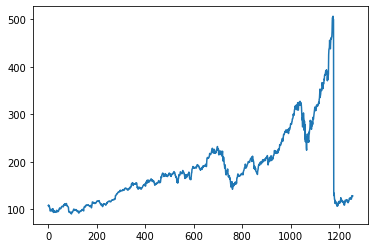

In [9]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [10]:
### LSTM are sensitive to the scale of the data. so we apply MinMax scaler
import numpy as np


In [11]:

from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [12]:
df1

array([[0.04254961],
       [0.03963921],
       [0.04425737],
       ...,
       [0.09226699],
       [0.08734817],
       [0.0911365 ]])

In [13]:
##splitting dataset into train and test split
# in time series
# we can use crossvalidation beacuse that choose randmly mean that loos the time stamp imformation so we can split by self
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [14]:
# convert an array of values into a dataset matrix
# timestep is that how much day previous depend on predict next day
# example seq is ---> 120,110,125,145,135
# timestep=3
# 120 110 125 o/p=145....
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [15]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [16]:
print(X_train.shape), print(y_train.shape)
print(X_test.shape), print(ytest.shape)


(716, 100)
(716,)
(339, 100)
(339,)


(None, None)

In [17]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [18]:

### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [19]:

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [20]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)


Epoch 1/100
12/12 [==============================] - 8s 305ms/step - loss: 0.0134 - val_loss: 0.0489
Epoch 2/100
12/12 [==============================] - 2s 193ms/step - loss: 0.0018 - val_loss: 0.0209
Epoch 3/100
12/12 [==============================] - 2s 197ms/step - loss: 6.1556e-04 - val_loss: 0.0220
Epoch 4/100
12/12 [==============================] - 2s 193ms/step - loss: 4.8863e-04 - val_loss: 0.0195
Epoch 5/100
12/12 [==============================] - 2s 195ms/step - loss: 4.1862e-04 - val_loss: 0.0189
Epoch 6/100
12/12 [==============================] - 2s 194ms/step - loss: 3.6411e-04 - val_loss: 0.0186
Epoch 7/100
12/12 [==============================] - 2s 194ms/step - loss: 3.2999e-04 - val_loss: 0.0181
Epoch 8/100
12/12 [==============================] - 2s 196ms/step - loss: 2.8889e-04 - val_loss: 0.0178
Epoch 9/100
12/12 [==============================] - 2s 196ms/step - loss: 3.2024e-04 - val_loss: 0.0175
Epoch 10/100
12/12 [==============================] - 2s 208ms/

In [22]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)


In [23]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [24]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

159.35881081661037

In [25]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

258.6578728217227

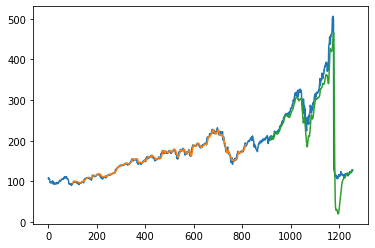

In [29]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()